In [1]:
from scipy.signal import welch, butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import scipy.signal as scs
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Functions for reprosessing

def minmax_normalize(chan: np.ndarray, min_value: int = 0, max_value: int = 1):
    chan = (chan - np.min(chan)) / (np.max(chan) - np.min(chan))
    return chan * (max_value - min_value) + min_value

def new_time_vector(df: pd.DataFrame, fs_new: int) -> np.ndarray:
    min_dt = df['timestamps_ecg'].iloc[-1]  # Last timestamp
    sampling_period = 1 / fs_new  # Time step for new sampling frequency
    n = int(fs_new * min_dt)  # Total number of samples
    return np.arange(0, n + 1) * sampling_period  # Generate uniform time array

def resample(chan: np.ndarray, orig_ts: np.ndarray, new_ts: np.ndarray) -> list[float]:
    sampled_signal = interp1d(orig_ts, chan, kind='cubic')
    return sampled_signal(new_ts)

def butter_filter(chan: np.ndarray, fs: int, N: int = 3, lf: float = 0.5, hf: float = 40):
    b, a = butter(N, [lf, hf], fs = fs, btype = 'bandpass')  
    return filtfilt(b, a, chan)  

Ex. 1

Implement a suitable processing before a peak detection. Also, try to create a derivative filter for 
t-wave suppression. Do the processing for ECG. 

In [4]:
#read the data
clean_signals = pd.read_csv('ecg_ppg_clean.csv') 
motion_signals = pd.read_csv('ecg_ppg_motion.csv')

# Display the data
display(clean_signals.head())
display(motion_signals.head())

,timestamps_ecg,ecg,timestamps_ppg_1_green,ppg_1_green,timestamps_ppg_1_red,ppg_1_red,timestamps_ppg_1_ir,ppg_1_ir,timestamps_ppg_2_green,ppg_2_green,timestamps_ppg_2_red,ppg_2_red,timestamps_ppg_2_ir,ppg_2_ir
0,725290.0,-1949.000000,725314.0,31289.000000,725314.0,2.274565e+06,725314.0,2.544369e+06,725301.0,28101.000000,725301.0,2.534342e+06,725301.0,2.540145e+06
1,725368.0,-1737.708861,725414.0,31255.336634,725414.0,2.274575e+06,725414.0,2.544328e+06,725401.0,28117.666667,725401.0,2.534269e+06,725401.0,2.539954e+06
2,725446.0,-1534.215190,725514.0,31204.029703,725514.0,2.274564e+06,725514.0,2.544304e+06,725501.0,28114.156863,725501.0,2.534142e+06,725501.0,2.539586e+06
3,725524.0,-1413.556962,725614.0,31186.504950,725614.0,2.274553e+06,725614.0,2.544289e+06,725601.0,28101.764706,725601.0,2.533956e+06,725601.0,2.539082e+06
4,725602.0,-1333.050633,725714.0,31166.029412,725714.0,2.274524e+06,725714.0,2.544271e+06,725701.0,28083.490196,725701.0,2.533720e+06,725701.0,2.538444e+06


,timestamps_ecg,ecg,timestamps_ppg_1_green,ppg_1_green,timestamps_ppg_1_red,ppg_1_red,timestamps_ppg_1_ir,ppg_1_ir,timestamps_ppg_2_green,ppg_2_green,timestamps_ppg_2_red,ppg_2_red,timestamps_ppg_2_ir,ppg_2_ir
0,763530.0,-1395.000000,763536.0,30428.000000,763536.0,2.275115e+06,763536.0,2.546066e+06,763512.0,21303.000000,763512.0,2.273412e+06,763512.0,2.267852e+06
1,763608.0,-1353.531646,763636.0,30448.792079,763636.0,2.275110e+06,763636.0,2.546067e+06,763612.0,21315.745098,763612.0,2.273418e+06,763612.0,2.267880e+06
2,763686.0,-1101.531646,763736.0,30440.178218,763736.0,2.275118e+06,763736.0,2.546061e+06,763712.0,21326.673267,763712.0,2.273422e+06,763712.0,2.267867e+06
3,763764.0,-878.544304,763836.0,30463.058824,763836.0,2.275130e+06,763836.0,2.546074e+06,763812.0,21333.656863,763812.0,2.273415e+06,763812.0,2.267844e+06
4,763842.0,-820.632911,763936.0,30473.504950,763936.0,2.275127e+06,763936.0,2.546079e+06,763912.0,21345.176471,763912.0,2.273398e+06,763912.0,2.267842e+06


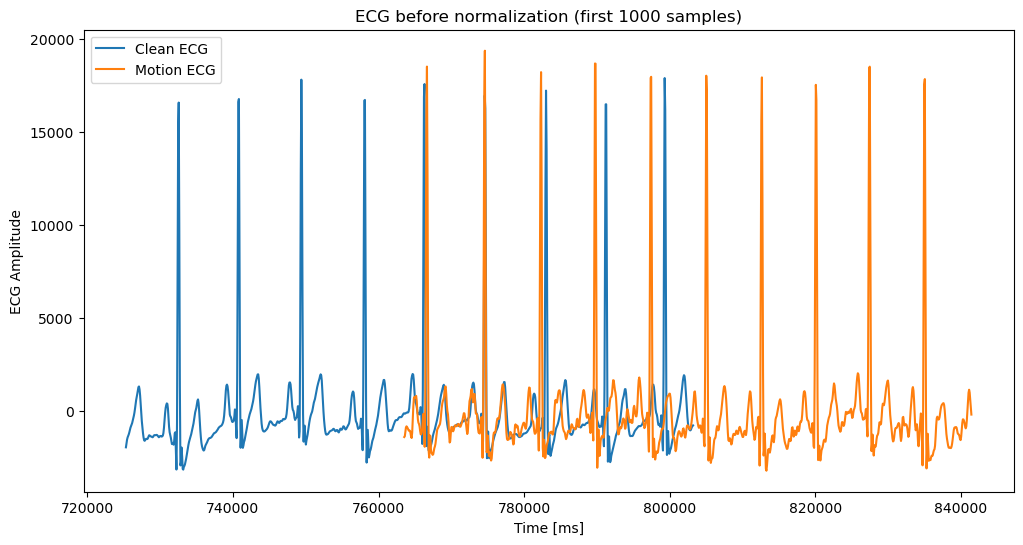

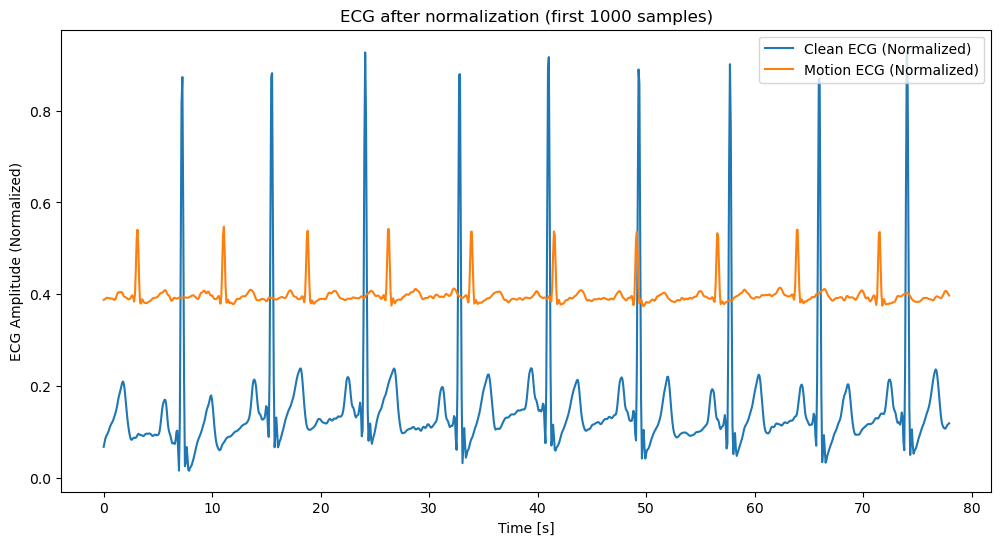

In [7]:
#Next using the preprocessing functions to process signals before peak detection

#Using the frequency that was presented previous exercises. 
fs_new = 200

# taking copies, that we don't overwrite the orginal datframes
normalized_clean = clean_signals.copy()
normalized_motion = motion_signals.copy()

# Convert timestamps from milliseconds to seconds
normalized_clean['timestamps_ecg'] = (clean_signals['timestamps_ecg'] - clean_signals['timestamps_ecg'].values[0]) / 1000
normalized_motion['timestamps_ecg'] = (motion_signals['timestamps_ecg'] - motion_signals['timestamps_ecg'].values[0]) / 1000
normalized_clean['timestamps_ppg_1_green'] = (clean_signals['timestamps_ppg_1_green'] - clean_signals['timestamps_ppg_1_green'].values[0]) / 1000
normalized_motion['timestamps_ppg_1_green'] = (motion_signals['timestamps_ppg_1_green'] - motion_signals['timestamps_ppg_1_green'].values[0]) / 1000

# Normalize ECG signals
normalized_clean['ecg'] = minmax_normalize(clean_signals['ecg'].dropna())
normalized_motion['ecg'] = minmax_normalize(motion_signals['ecg'].dropna())

#I also normalize the PPG signals that I can use it on the last task
normalized_clean['ppg_1_green'] = -normalized_clean['ppg_1_green']
normalized_clean['ppg_1_green'] = minmax_normalize(clean_signals['ppg_1_green'].dropna())

# Plot the ECG signals before normalization
plt.figure(figsize=(12, 6))
plt.title('ECG before normalization (first 1000 samples)')
sns.lineplot(x=clean_signals['timestamps_ecg'][:1000], y=clean_signals['ecg'][:1000], label='Clean ECG')
sns.lineplot(x=motion_signals['timestamps_ecg'][:1000], y=motion_signals['ecg'][:1000], label='Motion ECG')
plt.xlabel('Time [ms]')
plt.ylabel('ECG Amplitude')
plt.legend()
plt.show()

# Plot the ECG signals after normalization
plt.figure(figsize=(12, 6))
plt.title('ECG after normalization (first 1000 samples)')
sns.lineplot(x=normalized_clean['timestamps_ecg'][:1000], y=normalized_clean['ecg'][:1000], label='Clean ECG (Normalized)')
sns.lineplot(x=normalized_motion['timestamps_ecg'][:1000], y=normalized_motion['ecg'][:1000], label='Motion ECG (Normalized)')
plt.xlabel('Time [s]')
plt.ylabel('ECG Amplitude (Normalized)')
plt.legend()
plt.show()

In [10]:
# Focusing now on only on ECG and its timestamp
sig_cols = ['ecg']  # Signal column
ts_cols = ['timestamps_ecg']  # Timestamp column

# Initialize new DataFrames for resampled data
resampled_clean_data = pd.DataFrame(columns=['time', 'ecg'])
resampled_motion_data = pd.DataFrame(columns=['time', 'ecg'])

# Generate new time vectors
time_new_clean = new_time_vector(normalized_clean, fs_new)
resampled_clean_data['time'] = time_new_clean

time_new_motion = new_time_vector(normalized_motion, fs_new)
resampled_motion_data['time'] = time_new_motion

# Resample only ECG signals
resampled_clean_data['ecg'] = resample(normalized_clean['ecg'].dropna(), normalized_clean['timestamps_ecg'].dropna(), time_new_clean)
resampled_motion_data['ecg'] = resample(normalized_motion['ecg'].dropna(), normalized_motion['timestamps_ecg'].dropna(), time_new_motion)

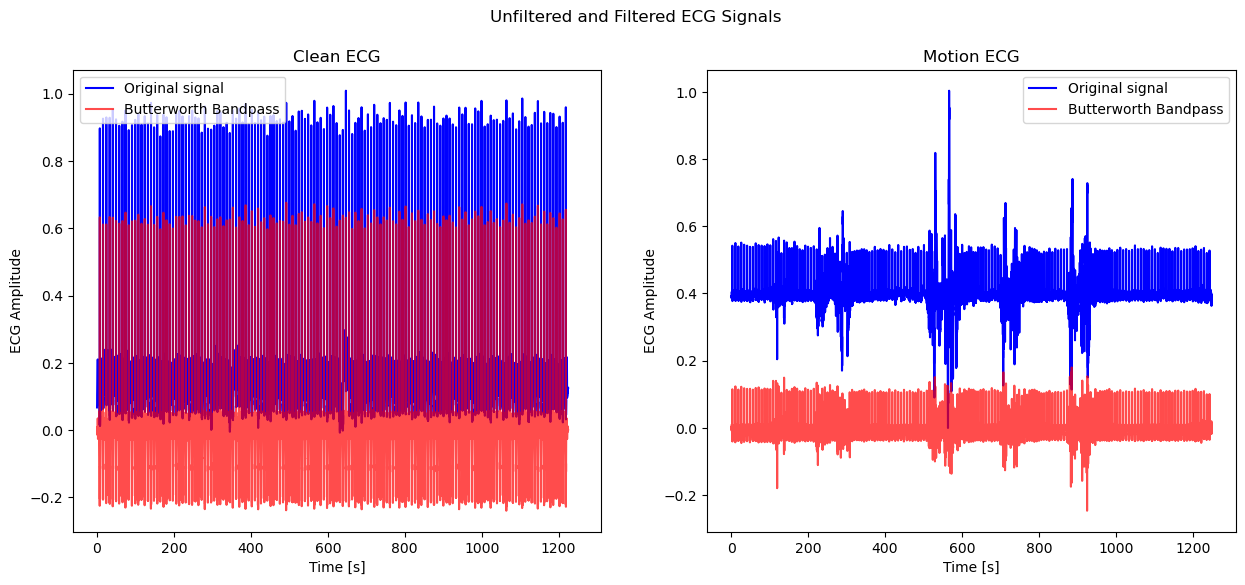

In [12]:
# then filtering the signals with butterworth filter

# Apply Butterworth bandpass filter to clean and motion ECG signals
bf_ecg_clean = butter_filter(resampled_clean_data['ecg'], fs_new)
bf_ecg_motion = butter_filter(resampled_motion_data['ecg'], fs_new)

# Ensure the filtered signals have the same length as time vectors
bf_ecg_clean = bf_ecg_clean[:len(resampled_clean_data['time'])]
bf_ecg_motion = bf_ecg_motion[:len(resampled_motion_data['time'])]

# Plot the Unfiltered vs. Filtered ECG Signals
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
fig.suptitle('Unfiltered and Filtered ECG Signals')

# Plot for Clean ECG Signal
sns.lineplot(data=resampled_clean_data, x='time', y='ecg', label='Original signal', color='blue', ax=ax[0])
sns.lineplot(x=resampled_clean_data['time'], y=bf_ecg_clean, label='Butterworth Bandpass', color='red', alpha=0.7, ax=ax[0])
ax[0].set(title='Clean ECG', xlabel='Time [s]', ylabel='ECG Amplitude')

# Plot for Motion ECG Signal
sns.lineplot(data=resampled_motion_data, x='time', y='ecg', label='Original signal', color='blue', ax=ax[1])
sns.lineplot(x=resampled_motion_data['time'], y=bf_ecg_motion, label='Butterworth Bandpass', color='red', alpha=0.7, ax=ax[1])
ax[1].set(title='Motion ECG', xlabel='Time [s]', ylabel='ECG Amplitude')

plt.legend()
plt.show()

In [18]:
# the derivative filter

def derivative_filter_ecg(signal, fs):
    """
    The filter coefficients are based on:
    - 1st derivative to highlight sharp changes in QRS
    - Scaling by fs / 8 for proper amplitude correction
    """
    b = np.array([1, 2, 0, -2, -1]) * fs / 8  
    ecg_derivative = scs.filtfilt(b, 1, signal) 
    ecg_derivative = ecg_derivative / np.abs(ecg_derivative).max() 
    
    return ecg_derivative

# Apply the derivative filter
derivative_ecg_clean = derivative_filter_ecg(bf_ecg_clean, fs_new)
derivative_ecg_motion = derivative_filter_ecg(bf_ecg_motion, fs_new)

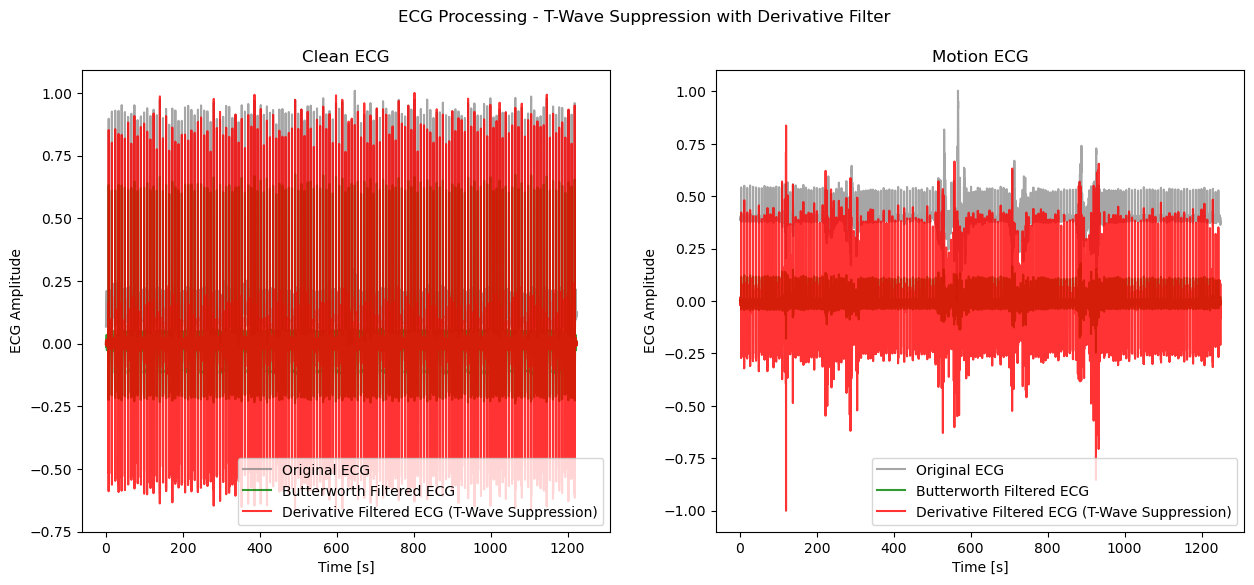

In [20]:
# Plot the results: Original, Butterworth Filtered, and Derivative Filtered ECG
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
fig.suptitle('ECG Processing - T-Wave Suppression with Derivative Filter')

# Clean ECG Plot
ax[0].plot(resampled_clean_data['time'], resampled_clean_data['ecg'], label='Original ECG', color='grey', alpha=0.7)
ax[0].plot(resampled_clean_data['time'], bf_ecg_clean, label='Butterworth Filtered ECG', color='green', alpha=0.8)
ax[0].plot(resampled_clean_data['time'], derivative_ecg_clean, label='Derivative Filtered ECG (T-Wave Suppression)', color='red', alpha=0.8)
ax[0].set(title='Clean ECG', xlabel='Time [s]', ylabel='ECG Amplitude')
ax[0].legend()

# Motion ECG Plot
ax[1].plot(resampled_motion_data['time'], resampled_motion_data['ecg'], label='Original ECG', color='grey', alpha=0.7)
ax[1].plot(resampled_motion_data['time'], bf_ecg_motion, label='Butterworth Filtered ECG', color='green', alpha=0.8)
ax[1].plot(resampled_motion_data['time'], derivative_ecg_motion, label='Derivative Filtered ECG (T-Wave Suppression)', color='red', alpha=0.8)
ax[1].set(title='Motion ECG', xlabel='Time [s]', ylabel='ECG Amplitude')
ax[1].legend()

plt.show()

Ex. 2

Create peak detection algorithm based on finding local maximums. (it does not have to be complicated and you do not need to create one specifically for ppg and for ecg).

In [23]:
#Before trying to find the peaks we need some preprocessing still

def square_signal(signal):
    return signal ** 2

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# Square the Butterworth & Derivative Filtered ECG
squared_ecg_clean = square_signal(derivative_ecg_clean)
squared_ecg_motion = square_signal(derivative_ecg_motion)

# Apply Moving Window Integration (MWI) (Typical window ~150ms)
window_size = int(0.15 * fs_new)  # Convert 150ms to sample points
mwi_ecg_clean = moving_average(squared_ecg_clean, window_size)
mwi_ecg_motion = moving_average(squared_ecg_motion, window_size)

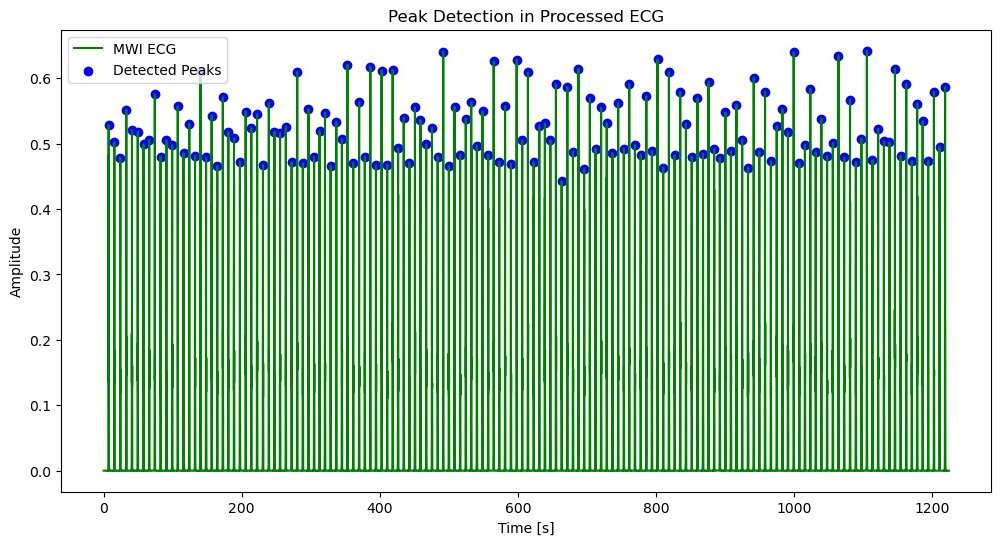

In [25]:
# Detect peaks in MWI ECG signal
peaks, _ = scs.find_peaks(mwi_ecg_clean, height=np.mean(mwi_ecg_clean) * 1.2, distance=int(0.6 * fs_new))
peak_times = resampled_clean_data['time'].iloc[peaks].values

# Plot detected peaks
plt.figure(figsize=(12, 6))
plt.plot(resampled_clean_data['time'], mwi_ecg_clean, label='MWI ECG', color='green')
plt.scatter(resampled_clean_data['time'][peaks], mwi_ecg_clean[peaks], color='blue', label='Detected Peaks')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Peak Detection in Processed ECG')
plt.show()

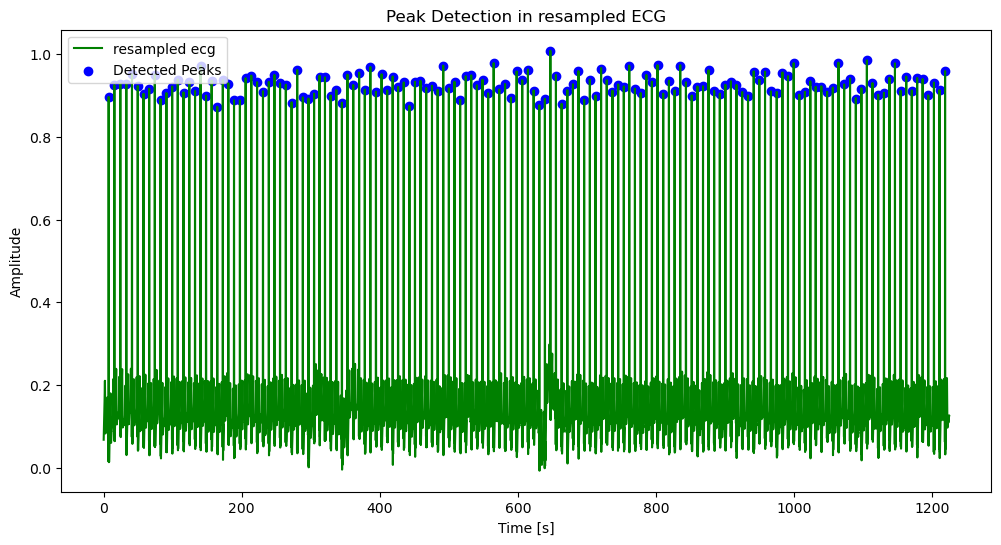

In [27]:
# Plot detected peaks
plt.figure(figsize=(12, 6))
plt.plot(resampled_clean_data['time'], resampled_clean_data['ecg'], label='resampled ecg', color='green')
plt.scatter(resampled_clean_data['time'][peaks], resampled_clean_data['ecg'][peaks], color='blue', label='Detected Peaks')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Peak Detection in resampled ECG')
plt.show()

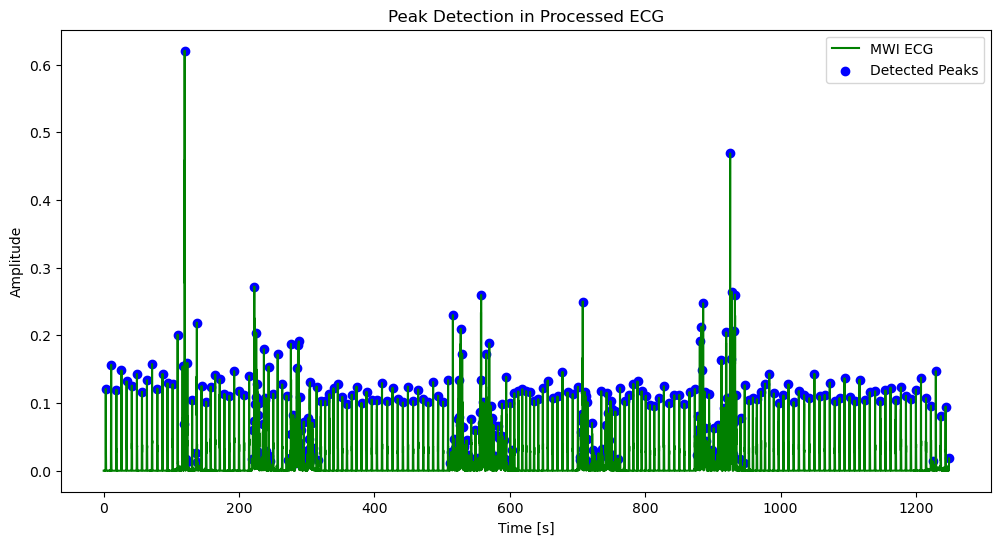

In [29]:
# Detect peaks in MWI ECG signal
peaks_m, _ = scs.find_peaks(mwi_ecg_motion, height=np.mean(mwi_ecg_motion) * 1.2, distance=int(0.6 * fs_new))
peak_times_m = resampled_motion_data['time'].iloc[peaks_m].values

# Plot detected peaks
plt.figure(figsize=(12, 6))
plt.plot(resampled_motion_data['time'], mwi_ecg_motion, label='MWI ECG', color='green')
plt.scatter(resampled_motion_data['time'][peaks_m], mwi_ecg_motion[peaks_m], color='blue', label='Detected Peaks')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Peak Detection in Processed ECG')
plt.show()

I tried to follow the 
Pan–Tompkins algorithm, but I'm not entirely convinced if I found the desired r-peaks or not.

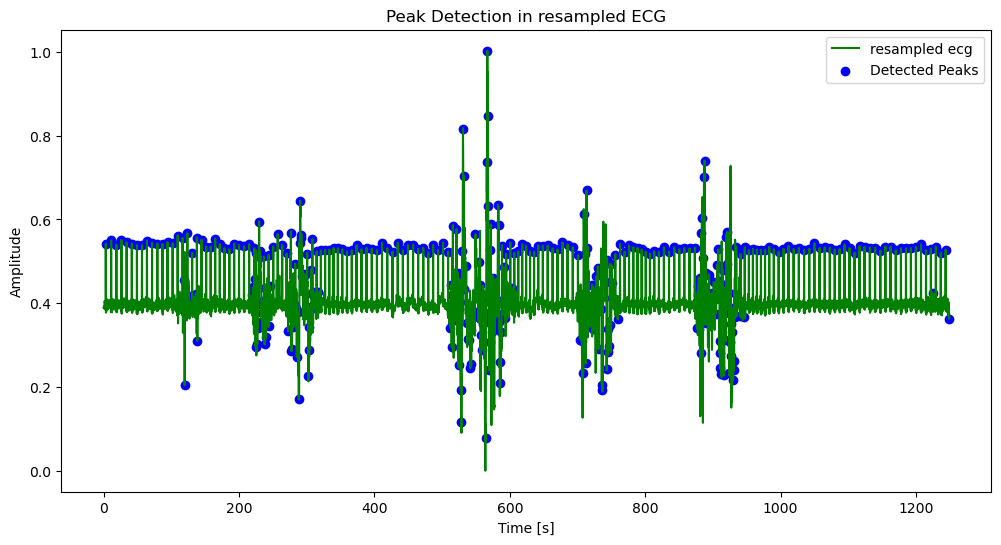

In [32]:
# Plot detected peaks
plt.figure(figsize=(12, 6))
plt.plot(resampled_motion_data['time'], resampled_motion_data['ecg'], label='resampled ecg', color='green')
plt.scatter(resampled_motion_data['time'][peaks_m], resampled_motion_data['ecg'][peaks_m], color='blue', label='Detected Peaks')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Peak Detection in resampled ECG')
plt.show()

3. Compute heart rate and remove beat locations that are physiologically impossible based on beat 
interval. 

In [35]:
#Function to detect the invalid beat locations

def filter_hr_peaks(peaks, kernel_size=7, hr_max_diff=16, hr_min=40, hr_max=180):
    
    peaks = np.copy(peaks) 
    peaks_med = scs.medfilt(peaks, kernel_size)
    idxs = (np.abs(peaks - peaks_med) < hr_max_diff) & (peaks_med > hr_min) & (peaks_med < hr_max)
    peaks[~idxs] = np.nan
    return peaks

In [39]:
# Compute heart rates from RR intervals
heart_rates_clean = 60 / np.diff(peak_times)  
heart_rates_motion = 60 / np.diff(peak_times_m)  

display(heart_rates_clean, heart_rates_motion)

# Apply filtering
filtered_heart_rates_clean = filter_hr_peaks(heart_rates_clean)
filtered_heart_rates_motion = filter_hr_peaks(heart_rates_motion)

# Plot Original vs. Filtered Heart Rate
plt.figure(figsize=(12, 6))
plt.plot(resampled_motion_data['time'][1:][~np.isnan(heart_rates_motion)], heart_rates_motion, 'o-', label='Original HR', color='gray', alpha=0.6)
plt.plot(resampled_motion_data['time'][1:][~np.isnan(filtered_heart_rates_motion)], filtered_heart_rates_motion, 'o-', label='Filtered HR', color='red')
plt.axhline(y=40, color='blue', linestyle='--', label='Min HR (40 BPM)')
plt.axhline(y=180, color='blue', linestyle='--', label='Max HR (180 BPM)')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate (BPM)')
plt.title('Heart Rate Before and After Filtering')
plt.legend()
plt.show()

array([7.25952813, 6.95652174, 6.90448792, 7.32600733, 7.1942446 ,
       7.14285714, 7.29927007, 7.41198271, 7.18993409, 7.06297822,
       7.1942446 , 7.43955363, 7.20288115, 7.15137068, 7.21587492,
       7.51408892, 7.50469043, 7.43494424, 7.35294118, 7.47198007,
       7.53295669, 7.25952813, 7.04225352, 7.20288115, 7.32600733,
       7.18132855, 7.01754386, 7.09639267, 7.3755378 , 7.35294118,
       7.19856029, 7.18132855, 7.3755378 , 7.3800738 , 7.31707317,
       7.38461538, 7.6142132 , 7.60456274, 7.36196319, 7.26832223,
       7.41656366, 7.46733043, 7.12589074, 7.04638873, 7.29927007,
       7.48596382, 7.38461538, 7.34843846, 7.40283775, 7.55191945,
       7.61904762, 7.3664825 , 7.26832223, 7.47663551, 7.54242615,
       7.19856029, 7.17703349, 7.2815534 , 7.43034056, 7.3800738 ,
       7.33496333, 7.33944954, 7.3800738 , 7.57575758, 7.32153752,
       7.33496333, 7.35744942, 7.50938673, 7.43034056, 7.12589074,
       7.0713023 , 7.24200362, 7.41656366, 7.2815534 , 7.23327

array([  7.54716981,   7.76699029,   8.03212851,   7.84826684,
         7.85854617,   7.90513834,   8.03750837,   8.17438692,
         7.93126239,   7.70218228,   7.84826684,   8.08625337,
         8.00533689,   8.05369128,   8.26446281,  26.25820569,
        75.        ,  24.5398773 ,  83.33333333,  72.72727273,
         8.48656294,  10.78167116,  43.16546763,  85.10638298,
         9.63855422,   8.82352941,   8.99550225,   8.98203593,
         8.8823094 ,   8.70195794,   8.25309491,   8.43288826,
         8.39748076,   8.13559322,   7.90513834,  13.12910284,
        58.53658537,  60.60606061,  57.69230769,  58.82352941,
        71.85628743,  64.51612903,  67.03910615,  82.75862069,
        59.70149254,  34.68208092,  47.43083004,  85.10638298,
        29.19708029,  91.60305344,  56.33802817,  45.11278195,
        54.05405405,  51.06382979,  67.03910615,  15.97869507,
        86.95652174,  44.11764706,  12.53918495,   9.13242009,
         9.02255639,   9.27357032,  25.75107296,  36.25

IndexError: Boolean index has wrong length: 366 instead of 249771

<Figure size 1200x600 with 0 Axes>

In [41]:
# I know that the problem is my peak_times and the peak_times_m, because the aren't correct,
# the interval between beats are over few seconds now, why the heart-reat aren't correct and I can't detect
# I can't detect the impossible peak locations

display(peak_times)
display(peak_times_m)

array([   7.225,   15.49 ,   24.115,   32.805,   40.995,   49.335,
         57.735,   65.955,   74.05 ,   82.395,   90.89 ,   99.23 ,
        107.295,  115.625,  124.015,  132.33 ,  140.315,  148.31 ,
        156.38 ,  164.54 ,  172.57 ,  180.535,  188.8  ,  197.32 ,
        205.65 ,  213.84 ,  222.195,  230.745,  239.2  ,  247.335,
        255.495,  263.83 ,  272.185,  280.32 ,  288.45 ,  296.65 ,
        304.775,  312.655,  320.545,  328.695,  336.95 ,  345.04 ,
        353.075,  361.495,  370.01 ,  378.23 ,  386.245,  394.37 ,
        402.535,  410.64 ,  418.585,  426.46 ,  434.605,  442.86 ,
        450.885,  458.84 ,  467.175,  475.535,  483.775,  491.85 ,
        499.98 ,  508.16 ,  516.335,  524.465,  532.385,  540.58 ,
        548.76 ,  556.915,  564.905,  572.98 ,  581.4  ,  589.885,
        598.17 ,  606.26 ,  614.5  ,  622.795,  631.   ,  639.075,
        646.995,  655.075,  663.32 ,  671.6  ,  679.74 ,  687.7  ,
        695.95 ,  704.205,  712.41 ,  720.495,  728.67 ,  736.

array([   3.105,   11.055,   18.78 ,   26.25 ,   33.895,   41.53 ,
         49.12 ,   56.585,   63.925,   71.49 ,   79.28 ,   86.925,
         94.345,  101.84 ,  109.29 ,  116.55 ,  118.835,  119.635,
        122.08 ,  122.8  ,  123.625,  130.695,  136.26 ,  137.65 ,
        138.355,  144.58 ,  151.38 ,  158.05 ,  164.73 ,  171.485,
        178.38 ,  185.65 ,  192.765,  199.91 ,  207.285,  214.875,
        219.445,  220.47 ,  221.46 ,  222.5  ,  223.52 ,  224.355,
        225.285,  226.18 ,  226.905,  227.91 ,  229.64 ,  230.905,
        231.61 ,  233.665,  234.32 ,  235.385,  236.715,  237.825,
        239.   ,  239.895,  243.65 ,  244.34 ,  245.7  ,  250.485,
        257.055,  263.705,  270.175,  272.505,  274.16 ,  275.795,
        276.555,  277.155,  278.125,  279.12 ,  280.08 ,  281.63 ,
        283.035,  283.89 ,  284.62 ,  285.24 ,  286.39 ,  287.095,
        288.245,  289.35 ,  290.13 ,  290.915,  291.94 ,  292.55 ,
        295.575,  297.205,  300.64 ,  301.42 ,  302.14 ,  302.

When I was working on the tasks and searching for help online, I found the website https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/. Using this site, I tried to find at least some answers to the tasks.

In [44]:
pip install heartpy

Note: you may need to restart the kernel to use updated packages.


In [45]:
import heartpy as hp

C:\Users\matil\anaconda3\Lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


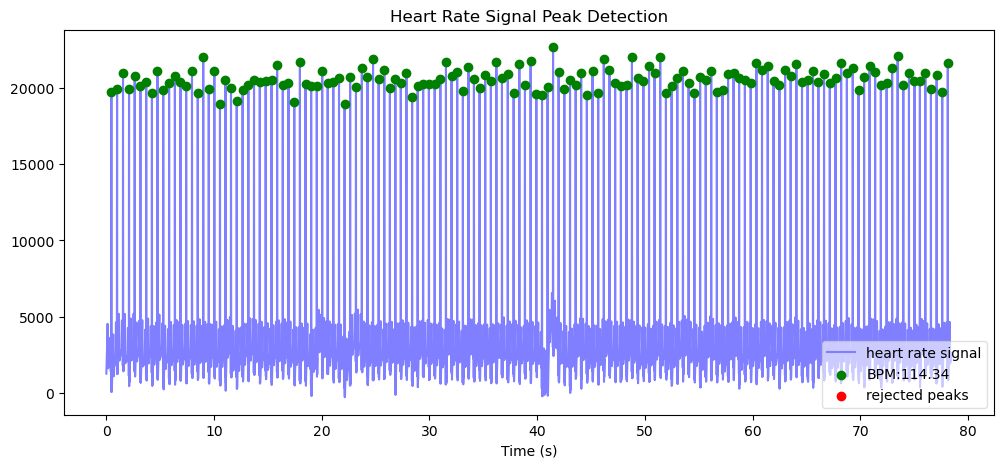

In [48]:
data = hp.get_data('ecg_ppg_clean.csv')
working_data, measures = hp.process(data[1:,1], fs_new)
r_peaks = working_data['peaklist']
hp.plotter(working_data, measures, figsize=(12,5))

C:\Users\matil\anaconda3\Lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


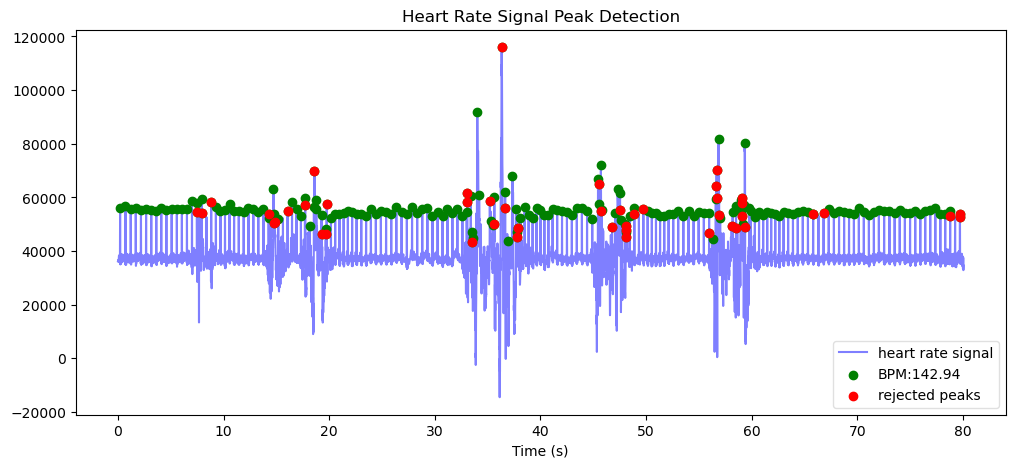

In [50]:
data_m = hp.get_data('ecg_ppg_motion.csv')
working_data_m, measures_m = hp.process(data_m[1:,1], fs_new)
r_peaks_m = working_data_m['peaklist']
hp.plotter(working_data_m, measures_m, figsize=(12,5))

In [52]:
rr_clean = hp.analysis.calc_rr(r_peaks, fs_new, working_data)
rr_motion = hp.analysis.calc_rr(r_peaks_m, fs_new, working_data_m)

display(rr_clean['RR_list'], rr_motion['RR_list'])

array([530., 550., 560., 525., 530., 540., 530., 515., 535., 545., 535.,
       520., 530., 540., 535., 510., 510., 520., 520., 515., 510., 530.,
       550., 530., 530., 535., 545., 545., 520., 525., 530., 535., 525.,
       520., 525., 520., 505., 510., 520., 530., 520., 515., 540., 545.,
       525., 515., 520., 525., 520., 505., 505., 525., 530., 515., 510.,
       530., 540., 525., 520., 520., 525., 525., 520., 505., 525., 525.,
       525., 510., 520., 540., 545., 530., 520., 525., 530., 530., 515.,
       510., 515., 530., 530., 525., 510., 525., 530., 525., 520., 525.,
       530., 530., 525., 505., 525., 535., 525., 515., 525., 530., 525.,
       530., 520., 530., 540., 530., 520., 510., 520., 530., 515., 510.,
       515., 535., 540., 530., 520., 530., 545., 540., 530., 515., 530.,
       525., 520., 500., 500., 525., 535., 530., 525., 530., 545., 535.,
       520., 510., 515., 530., 535., 515., 510., 525., 525., 510., 505.,
       505., 520., 530., 520., 515.])

array([ 510.,  495.,  475.,  495.,  485.,  490.,  475.,  475.,  485.,
        495.,  490.,  480.,  480.,  475.,  465.,    5.,  450.,    5.,
        895.,  445.,  435.,  425.,  430.,  435.,  440.,  465.,  455.,
        460.,  470.,  490.,  485.,    5.,  455.,   10.,   70.,   50.,
        325.,  880.,  425.,  425.,  415.,  405.,    5.,  410.,  410.,
         50.,  115.,   60.,  495.,   10.,  390.,   50.,   40.,  400.,
        405.,  405.,  395.,  400.,  405.,  420.,  445.,  455.,  455.,
        470.,  475.,  495.,  490.,  480.,  495.,  500.,  495.,  485.,
        480.,  485.,  480.,  485.,  470.,  465.,  470.,  470.,  475.,
        405.,   50.,    5.,  330.,  110.,    5.,  110.,  400.,  170.,
       1010.,   80.,  265.,   85.,   10.,  680.,  335.,    5.,  235.,
        440.,  375.,   60.,    5.,   80.,   35.,  215.,  390.,  380.,
        375.,  375.,  370.,  375.,  380.,  395.,  435.,  460.,  465.,
        465.,  470.,  480.,  490.,  490.,  550.,   80.,   50.,  140.,
         15.,   70.,

In [54]:
min_rr= 273
max_rr= 1500

valid_intervals_c = rr_clean['RR_list'][(rr_clean['RR_list']>= min_rr) & (rr_clean['RR_list']<=max_rr)]
valid_intervals_m = rr_motion['RR_list'][(rr_motion['RR_list']>= min_rr) & (rr_motion['RR_list']<=max_rr)]

display(valid_intervals_c)
display(valid_intervals_m)

array([530., 550., 560., 525., 530., 540., 530., 515., 535., 545., 535.,
       520., 530., 540., 535., 510., 510., 520., 520., 515., 510., 530.,
       550., 530., 530., 535., 545., 545., 520., 525., 530., 535., 525.,
       520., 525., 520., 505., 510., 520., 530., 520., 515., 540., 545.,
       525., 515., 520., 525., 520., 505., 505., 525., 530., 515., 510.,
       530., 540., 525., 520., 520., 525., 525., 520., 505., 525., 525.,
       525., 510., 520., 540., 545., 530., 520., 525., 530., 530., 515.,
       510., 515., 530., 530., 525., 510., 525., 530., 525., 520., 525.,
       530., 530., 525., 505., 525., 535., 525., 515., 525., 530., 525.,
       530., 520., 530., 540., 530., 520., 510., 520., 530., 515., 510.,
       515., 535., 540., 530., 520., 530., 545., 540., 530., 515., 530.,
       525., 520., 500., 500., 525., 535., 530., 525., 530., 545., 535.,
       520., 510., 515., 530., 535., 515., 510., 525., 525., 510., 505.,
       505., 520., 530., 520., 515.])

array([ 510.,  495.,  475.,  495.,  485.,  490.,  475.,  475.,  485.,
        495.,  490.,  480.,  480.,  475.,  465.,  450.,  895.,  445.,
        435.,  425.,  430.,  435.,  440.,  465.,  455.,  460.,  470.,
        490.,  485.,  455.,  325.,  880.,  425.,  425.,  415.,  405.,
        410.,  410.,  495.,  390.,  400.,  405.,  405.,  395.,  400.,
        405.,  420.,  445.,  455.,  455.,  470.,  475.,  495.,  490.,
        480.,  495.,  500.,  495.,  485.,  480.,  485.,  480.,  485.,
        470.,  465.,  470.,  470.,  475.,  405.,  330.,  400., 1010.,
        680.,  335.,  440.,  375.,  390.,  380.,  375.,  375.,  370.,
        375.,  380.,  395.,  435.,  460.,  465.,  465.,  470.,  480.,
        490.,  490.,  550.,  975.,  310.,  320.,  305.,  445.,  850.,
        405.,  395.,  395.,  390.,  395.,  410.,  440.,  470.,  490.,
        490.,  475.,  480.,  490.,  505.,  370., 1085.,  320.,  415.,
        410.,  405.,  395.,  390.,  385.,  375.,  385.,  385.,  405.,
        430.,  455.,

Ex. 4. Estimate heart rate variability using Poincare and Lorentz plots.

In [57]:
# Compute First Difference (HR Variability), I'm using the intervals that I got from heartpy
drri = np.diff(valid_intervals_c)  # First difference (HRV measure)

# Compute Second Difference (HRV Complexity)
d2rri = np.diff(drri)  # Second difference

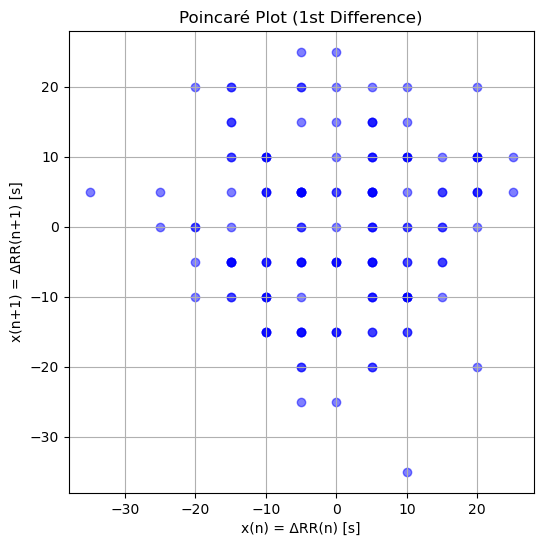

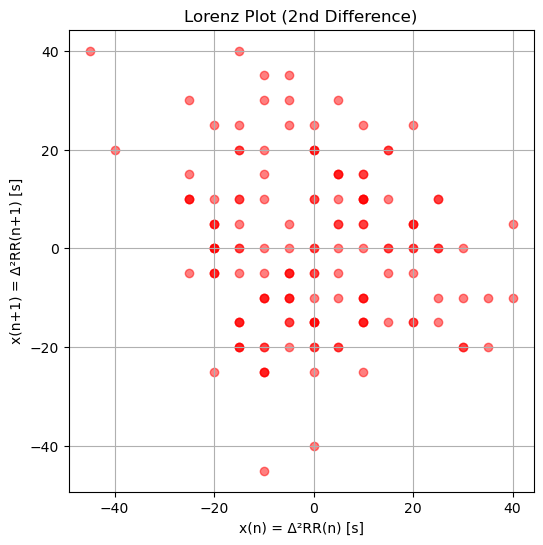

In [59]:
# Poincaré Plot (1st Difference)
plt.figure(figsize=(6,6))
plt.scatter(drri[:-1], drri[1:], alpha=0.5, color='blue')
plt.xlabel('x(n) = ΔRR(n) [s]')
plt.ylabel('x(n+1) = ΔRR(n+1) [s]')
plt.title('Poincaré Plot (1st Difference)')
plt.grid()
plt.show()

# Lorenz Plot (2nd Difference)
plt.figure(figsize=(6,6))
plt.scatter(d2rri[:-1], d2rri[1:], alpha=0.5, color='red')
plt.xlabel('x(n) = Δ²RR(n) [s]')
plt.ylabel('x(n+1) = Δ²RR(n+1) [s]')
plt.title('Lorenz Plot (2nd Difference)')
plt.grid()
plt.show()

C:\Users\matil\anaconda3\Lib\site-packages\heartpy\visualizeutils.py:299: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


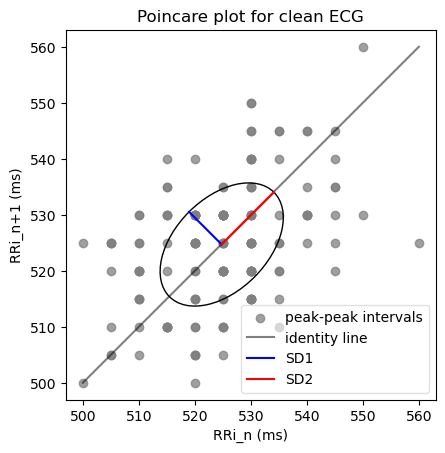

In [61]:
hp.plot_poincare(working_data, measures, title = 'Poincare plot for clean ECG')

C:\Users\matil\anaconda3\Lib\site-packages\heartpy\visualizeutils.py:299: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


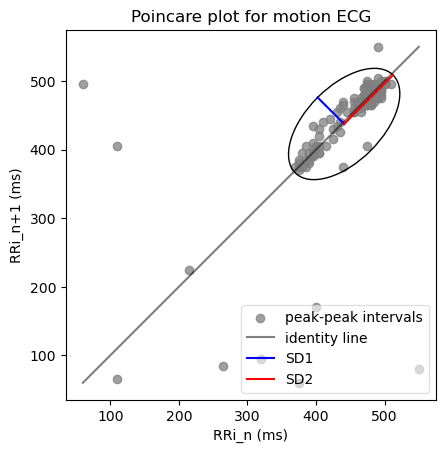

In [63]:
hp.plot_poincare(working_data_m, measures_m, title = 'Poincare plot for motion ECG')

5. Compute average time delay between ecg R-peak and PPG foot (peak onset). 

Average Pulse Transit Time (PTT): -0.9725 seconds


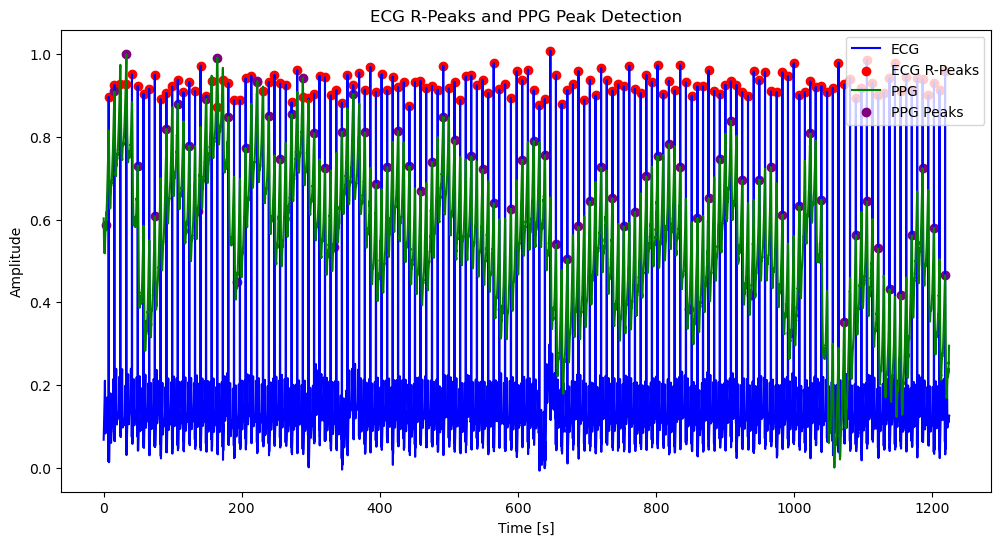

In [66]:
#Detect ECG R-peaks (Reliable Reference)
r_peaks, _ = scs.find_peaks(resampled_clean_data['ecg'], height=0.5, distance=int(0.6 * fs_new))
r_peak_times = resampled_clean_data['time'].iloc[r_peaks].values  # Convert indices to timestamps

# Detect PPG Peaks (Or PPG Foot as Onset)
ppg_signal = normalized_clean['ppg_1_green'].values  # Extract PPG signal
ppg_peaks, _ = scs.find_peaks(ppg_signal, height=0.3, distance=int(0.6 * fs_new))  # Find PPG systolic peaks
ppg_peak_times = normalized_clean['timestamps_ppg_1_green'].iloc[ppg_peaks].values  # Convert indices to timestamps

# Match Each ECG R-Peak to the Closest PPG Peak
ptt_values = []  # Store pulse transit time values
for r_time in r_peak_times:
    # Find the closest PPG peak to this R-peak
    closest_ppg_peak = ppg_peak_times[np.argmin(np.abs(ppg_peak_times - r_time))]
    
    # Compute time delay
    time_delay = closest_ppg_peak - r_time
    ptt_values.append(time_delay)

# Compute the Average PTT
average_ptt = np.mean(ptt_values)

# Print Results
print(f"Average Pulse Transit Time (PTT): {average_ptt:.4f} seconds")

# Step 6: Plot ECG and PPG with Detected Peaks
plt.figure(figsize=(12, 6))
plt.plot(resampled_clean_data['time'], resampled_clean_data['ecg'], label='ECG', color='blue')
plt.scatter(r_peak_times, resampled_clean_data['ecg'].iloc[r_peaks], color='red', label='ECG R-Peaks')

plt.plot(normalized_clean['timestamps_ppg_1_green'], normalized_clean['ppg_1_green'], label='PPG', color='green')
plt.scatter(ppg_peak_times, normalized_clean['ppg_1_green'].iloc[ppg_peaks], color='purple', label='PPG Peaks')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('ECG R-Peaks and PPG Peak Detection')
plt.show()

